In [32]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

# Get Data

In [2]:
test_df = pd.read_csv('test_simplified.csv')
test_df.shape

(112199, 3)

In [3]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [4]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]

In [5]:
# Convert the drawing column to matrix
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)
test_df['drawing'] = test_df['drawing'].apply(ast.literal_eval)

In [6]:
# train_df.head()
# train_df['recognized'].value_counts()

# Draw Sample

In [7]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
58432,US,"[[[224, 155, 101, 48, 4, 0, 1, 24, 8, 8, 15, 2...",6025269741617152,True,2017-01-31 15:04:55.242800,whale
28913,US,"[[[0, 12, 37, 60, 87, 141, 167, 208, 229, 230]...",6436131543449600,True,2017-03-09 01:29:38.781120,eye
23789,CZ,"[[[138, 143, 140, 19, 0, 87, 163, 143, 139], [...",4996008712863744,True,2017-01-23 15:43:33.836700,van
19345,US,"[[[0, 28, 82, 107, 132, 142, 188, 231, 238, 24...",6057230988214272,True,2017-03-21 16:21:46.418810,toe
9011,PT,"[[[5, 6, 11, 47, 59, 69, 89, 93, 100, 127, 168...",5228209576607744,True,2017-01-28 16:24:42.018400,rain
59981,GB,"[[[100, 78, 63, 44, 21, 6, 0, 38, 62, 61, 67, ...",6568193415970816,True,2017-03-23 12:57:06.044630,dog
44564,CA,"[[[85, 90, 100, 102, 126, 147, 167, 168, 170, ...",5337706760503296,True,2017-03-24 02:51:15.199980,lighthouse
61570,CA,"[[[51, 63, 67, 69, 68, 85, 151, 153, 153, 175,...",5830525098917888,True,2017-03-19 02:21:02.093680,mushroom
2106,RE,"[[[65, 106, 133, 149, 166, 191, 184, 108, 94, ...",5173995458527232,True,2017-03-15 14:08:10.347480,star
32340,HU,"[[[48, 41, 41, 44, 52, 91, 102, 109, 107, 93, ...",4955484987588608,True,2017-03-06 17:35:47.549710,firetruck


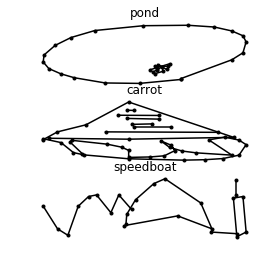

In [8]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [33]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [52]:
output_height = 32
output_width = 32
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)
test_df['img'] = test_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

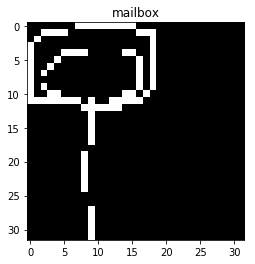

In [53]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [54]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [55]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [56]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [57]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))
imgArr_test = np.vstack(test_df['img'].values).flatten().reshape((test_df['img'].shape[0], img_rows, img_cols))

In [58]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')
imgArr_test = imgArr_test.reshape(imgArr_test.shape[0], img_rows, img_cols, 1).astype('float32')

In [59]:
y_train = train_df['word']

In [60]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [62]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [63]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*4, (3,3), input_shape=(img_rows,img_cols,1), activation='relu')) 
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [64]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 16)        3216      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 32)          4640      
__________

In [65]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 93s - loss: 6.6287 - acc: 0.0028 - top_3_accuracy: 0.0085 - categorical_crossentropy: 6.6287 - val_loss: 5.8289 - val_acc: 0.0022 - val_top_3_accuracy: 0.0088 - val_categorical_crossentropy: 5.8289
Epoch 2/500
 - 79s - loss: 5.8254 - acc: 0.0040 - top_3_accuracy: 0.0121 - categorical_crossentropy: 5.8254 - val_loss: 5.8125 - val_acc: 0.0069 - val_top_3_accuracy: 0.0177 - val_categorical_crossentropy: 5.8125
Epoch 3/500
 - 106s - loss: 5.7324 - acc: 0.0082 - top_3_accuracy: 0.0227 - categorical_crossentropy: 5.7324 - val_loss: 5.5404 - val_acc: 0.0161 - val_top_3_accuracy: 0.0398 - val_categorical_crossentropy: 5.5404
Epoch 4/500
 - 91s - loss: 5.4360 - acc: 0.0170 - top_3_accuracy: 0.0432 - categorical_crossentropy: 5.4360 - val_loss: 5.1854 - val_acc: 0.0340 - val_top_3_accuracy: 0.0828 - val_categorical_crossentropy: 5.1854
Epoch 5/500
 - 83s - loss: 5.1628 - acc: 0.0299 - top_3_accuracy: 0.0734 - categorical_crossentro

Epoch 40/500
 - 76s - loss: 2.7070 - acc: 0.3312 - top_3_accuracy: 0.5482 - categorical_crossentropy: 2.7070 - val_loss: 2.7909 - val_acc: 0.3485 - val_top_3_accuracy: 0.5546 - val_categorical_crossentropy: 2.7909
Epoch 41/500
 - 75s - loss: 2.6860 - acc: 0.3344 - top_3_accuracy: 0.5533 - categorical_crossentropy: 2.6860 - val_loss: 2.7755 - val_acc: 0.3513 - val_top_3_accuracy: 0.5578 - val_categorical_crossentropy: 2.7755
Epoch 42/500
 - 76s - loss: 2.6615 - acc: 0.3371 - top_3_accuracy: 0.5601 - categorical_crossentropy: 2.6615 - val_loss: 2.7538 - val_acc: 0.3582 - val_top_3_accuracy: 0.5635 - val_categorical_crossentropy: 2.7538
Epoch 43/500
 - 76s - loss: 2.6224 - acc: 0.3452 - top_3_accuracy: 0.5661 - categorical_crossentropy: 2.6224 - val_loss: 2.7636 - val_acc: 0.3534 - val_top_3_accuracy: 0.5613 - val_categorical_crossentropy: 2.7636
Epoch 44/500
 - 78s - loss: 2.5964 - acc: 0.3506 - top_3_accuracy: 0.5705 - categorical_crossentropy: 2.5964 - val_loss: 2.7650 - val_acc: 0.352

Epoch 79/500
 - 76s - loss: 2.0921 - acc: 0.4387 - top_3_accuracy: 0.6738 - categorical_crossentropy: 2.0921 - val_loss: 2.7452 - val_acc: 0.3749 - val_top_3_accuracy: 0.5773 - val_categorical_crossentropy: 2.7452
Epoch 80/500
 - 75s - loss: 2.0875 - acc: 0.4426 - top_3_accuracy: 0.6764 - categorical_crossentropy: 2.0875 - val_loss: 2.7473 - val_acc: 0.3711 - val_top_3_accuracy: 0.5796 - val_categorical_crossentropy: 2.7473
Epoch 81/500
 - 75s - loss: 2.0806 - acc: 0.4424 - top_3_accuracy: 0.6763 - categorical_crossentropy: 2.0806 - val_loss: 2.7575 - val_acc: 0.3666 - val_top_3_accuracy: 0.5804 - val_categorical_crossentropy: 2.7575
Epoch 82/500
 - 81s - loss: 2.0546 - acc: 0.4478 - top_3_accuracy: 0.6828 - categorical_crossentropy: 2.0546 - val_loss: 2.7615 - val_acc: 0.3688 - val_top_3_accuracy: 0.5748 - val_categorical_crossentropy: 2.7615
Epoch 83/500
 - 83s - loss: 2.0662 - acc: 0.4446 - top_3_accuracy: 0.6815 - categorical_crossentropy: 2.0662 - val_loss: 2.7455 - val_acc: 0.375

Epoch 118/500
 - 75s - loss: 1.8063 - acc: 0.4983 - top_3_accuracy: 0.7348 - categorical_crossentropy: 1.8063 - val_loss: 2.7875 - val_acc: 0.3763 - val_top_3_accuracy: 0.5796 - val_categorical_crossentropy: 2.7875
Epoch 119/500
 - 77s - loss: 1.8002 - acc: 0.4985 - top_3_accuracy: 0.7372 - categorical_crossentropy: 1.8002 - val_loss: 2.8197 - val_acc: 0.3680 - val_top_3_accuracy: 0.5758 - val_categorical_crossentropy: 2.8197
Epoch 120/500
 - 76s - loss: 1.8065 - acc: 0.4968 - top_3_accuracy: 0.7363 - categorical_crossentropy: 1.8065 - val_loss: 2.8159 - val_acc: 0.3759 - val_top_3_accuracy: 0.5820 - val_categorical_crossentropy: 2.8159
Epoch 121/500
 - 76s - loss: 1.7867 - acc: 0.5035 - top_3_accuracy: 0.7401 - categorical_crossentropy: 1.7867 - val_loss: 2.8360 - val_acc: 0.3723 - val_top_3_accuracy: 0.5824 - val_categorical_crossentropy: 2.8360
Epoch 122/500
 - 76s - loss: 1.7963 - acc: 0.5004 - top_3_accuracy: 0.7375 - categorical_crossentropy: 1.7963 - val_loss: 2.8228 - val_acc: 

Epoch 157/500
 - 75s - loss: 1.6734 - acc: 0.5291 - top_3_accuracy: 0.7636 - categorical_crossentropy: 1.6734 - val_loss: 2.9077 - val_acc: 0.3656 - val_top_3_accuracy: 0.5726 - val_categorical_crossentropy: 2.9077
Epoch 158/500
 - 75s - loss: 1.6669 - acc: 0.5291 - top_3_accuracy: 0.7620 - categorical_crossentropy: 1.6669 - val_loss: 2.9218 - val_acc: 0.3745 - val_top_3_accuracy: 0.5735 - val_categorical_crossentropy: 2.9218
Epoch 159/500
 - 76s - loss: 1.6590 - acc: 0.5318 - top_3_accuracy: 0.7672 - categorical_crossentropy: 1.6590 - val_loss: 2.9000 - val_acc: 0.3714 - val_top_3_accuracy: 0.5740 - val_categorical_crossentropy: 2.9000
Epoch 160/500
 - 75s - loss: 1.6407 - acc: 0.5342 - top_3_accuracy: 0.7691 - categorical_crossentropy: 1.6407 - val_loss: 2.9010 - val_acc: 0.3728 - val_top_3_accuracy: 0.5747 - val_categorical_crossentropy: 2.9010
Epoch 161/500
 - 75s - loss: 1.6505 - acc: 0.5312 - top_3_accuracy: 0.7646 - categorical_crossentropy: 1.6505 - val_loss: 2.8901 - val_acc: 

Epoch 196/500
 - 76s - loss: 1.5474 - acc: 0.5558 - top_3_accuracy: 0.7895 - categorical_crossentropy: 1.5474 - val_loss: 2.9663 - val_acc: 0.3648 - val_top_3_accuracy: 0.5729 - val_categorical_crossentropy: 2.9663
Epoch 197/500
 - 75s - loss: 1.5612 - acc: 0.5547 - top_3_accuracy: 0.7843 - categorical_crossentropy: 1.5612 - val_loss: 2.9397 - val_acc: 0.3695 - val_top_3_accuracy: 0.5745 - val_categorical_crossentropy: 2.9397
Epoch 198/500
 - 81s - loss: 1.5524 - acc: 0.5585 - top_3_accuracy: 0.7869 - categorical_crossentropy: 1.5524 - val_loss: 2.9199 - val_acc: 0.3735 - val_top_3_accuracy: 0.5816 - val_categorical_crossentropy: 2.9199
Epoch 199/500
 - 82s - loss: 1.5411 - acc: 0.5592 - top_3_accuracy: 0.7895 - categorical_crossentropy: 1.5411 - val_loss: 2.9805 - val_acc: 0.3703 - val_top_3_accuracy: 0.5741 - val_categorical_crossentropy: 2.9805
Epoch 200/500
 - 87s - loss: 1.5756 - acc: 0.5530 - top_3_accuracy: 0.7805 - categorical_crossentropy: 1.5756 - val_loss: 2.9688 - val_acc: 

Epoch 235/500
 - 75s - loss: 1.4919 - acc: 0.5696 - top_3_accuracy: 0.7993 - categorical_crossentropy: 1.4919 - val_loss: 2.9335 - val_acc: 0.3787 - val_top_3_accuracy: 0.5776 - val_categorical_crossentropy: 2.9335
Epoch 236/500
 - 76s - loss: 1.4891 - acc: 0.5726 - top_3_accuracy: 0.7983 - categorical_crossentropy: 1.4891 - val_loss: 2.9360 - val_acc: 0.3771 - val_top_3_accuracy: 0.5775 - val_categorical_crossentropy: 2.9360
Epoch 237/500
 - 76s - loss: 1.4905 - acc: 0.5697 - top_3_accuracy: 0.7990 - categorical_crossentropy: 1.4905 - val_loss: 3.0482 - val_acc: 0.3646 - val_top_3_accuracy: 0.5639 - val_categorical_crossentropy: 3.0482
Epoch 238/500
 - 76s - loss: 1.4921 - acc: 0.5721 - top_3_accuracy: 0.8018 - categorical_crossentropy: 1.4921 - val_loss: 2.9770 - val_acc: 0.3709 - val_top_3_accuracy: 0.5727 - val_categorical_crossentropy: 2.9770
Epoch 239/500
 - 75s - loss: 1.4896 - acc: 0.5741 - top_3_accuracy: 0.7995 - categorical_crossentropy: 1.4896 - val_loss: 2.9746 - val_acc: 

Epoch 274/500
 - 92s - loss: 1.4438 - acc: 0.5821 - top_3_accuracy: 0.8078 - categorical_crossentropy: 1.4438 - val_loss: 2.9839 - val_acc: 0.3728 - val_top_3_accuracy: 0.5765 - val_categorical_crossentropy: 2.9839
Epoch 275/500
 - 90s - loss: 1.4411 - acc: 0.5846 - top_3_accuracy: 0.8122 - categorical_crossentropy: 1.4411 - val_loss: 3.0125 - val_acc: 0.3724 - val_top_3_accuracy: 0.5745 - val_categorical_crossentropy: 3.0125
Epoch 276/500
 - 88s - loss: 1.4339 - acc: 0.5868 - top_3_accuracy: 0.8113 - categorical_crossentropy: 1.4339 - val_loss: 2.9985 - val_acc: 0.3713 - val_top_3_accuracy: 0.5734 - val_categorical_crossentropy: 2.9985
Epoch 277/500
 - 83s - loss: 1.4286 - acc: 0.5882 - top_3_accuracy: 0.8112 - categorical_crossentropy: 1.4286 - val_loss: 2.9858 - val_acc: 0.3748 - val_top_3_accuracy: 0.5783 - val_categorical_crossentropy: 2.9858
Epoch 278/500
 - 95s - loss: 1.4258 - acc: 0.5891 - top_3_accuracy: 0.8127 - categorical_crossentropy: 1.4258 - val_loss: 3.0107 - val_acc: 

KeyboardInterrupt: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [131]:
# X_train.shape

(27200, 50, 50, 1)